# Guided Project: Analyzing NYC High School Data
Main goal of that project is to find factors that influence academic performance with a focus on New York City public schools. **SAT, or Scholastic Aptitude Test** scores will be used to assess academic performance of senior grade students. The SAT has three sections, each of which is worth a maximum of **800 points**. Colleges use the SAT to determine which students to admit.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Further I'll combine the following data sets into a single, clean pandas dataframe:

 - [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) SAT scores for each high school of NYC for 2012.
 - [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) Attendance information for each school of NYC for 2010-2011.
 - [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) Information on class size for each school of NYC for 2010-2011.
 - [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) Advanced Placement (AP) exam results for each high school of NYC (passing an optional AP exam in a particular subject can earn a student college credit in that subject) for 2010-2011.
 - [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) the percentage of students who graduated, and other outcome information for each high school of NYC for 2005-2010.
 - [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) demographics information for each high school at NYC for 2006 - 2012.
 - [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) Surveys of parents, teachers, and students at each high school.
 - [School Directory](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2) directory with basic information on NYC schools for 2014-2015.

In course of the project I'll find answer to the following questions:

 - how do demographic factors as race, gender or income affect academic performance
 - are there factors in learning environment that can affect academic performance
 - how other learning activities are connected to high SAT scores


Finally there is always a big question: is there a causation between correlated measures. If certain factors will be identified it's worth evaluating if they are changing due to some third factor. 


# Data cleaning and preparation

First let's open all csv and txt files that will be used in the project and create a single dataframe from them. 



In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gpd
%matplotlib inline

In [2]:
data_files = [
    'ap_results.csv',
    'class_size.csv',
    'demographics.csv',
    'graduation.csv',
    'school_attendance.csv',
    'sat_scores.csv',
    'hs_directory.csv'
]

data = {}

for f in data_files:
    d = pd.read_csv('schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d


### Open survey datasets

In [3]:
# open txt files
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

# select necessary fields
survey_fields = [
    'dbn', 
    'rr_s', 
    'rr_t', 
    'rr_p', 
    'N_s', 
    'N_t', 
    'N_p', 
    'saf_p_11', 
    'com_p_11', 
    'eng_p_11', 
    'aca_p_11', 
    'saf_t_11', 
    'com_t_11', 
    'eng_t_11', 
    'aca_t_11', 
    'saf_s_11', 
    'com_s_11', 
    'eng_s_11', 
    'aca_s_11', 
    'saf_tot_11', 
    'com_tot_11', 
    'eng_tot_11', 
    'aca_tot_11',
]

# create dataframe with target fields
survey = survey.loc[:,survey_fields]
data['survey'] = survey

### Add DBN column to hs_directory

In [4]:
# create a single column with dbn number
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return '0' + string_representation
    
data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

### Convert columns to numeric

In [5]:
# convert target columns from 'sat_scores' to numeric 
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_scores"][c] = pd.to_numeric(data["sat_scores"][c], errors="coerce")

data['sat_scores']['sat_score'] = data['sat_scores'][cols[0]] + data['sat_scores'][cols[1]] + data['sat_scores'][cols[2]]

In [6]:
# convert target columns from 'ap_results' to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_results'][col] = pd.to_numeric(data['ap_results'][col], errors='coerce')

### Select target data
Next step is to select from 'demographics', 'class_size' and 'graduation' rows with data on high school general education programs for years 2011-2011 and rename columns from 'hs_directory' and 'survey' to keep consistent names for the key field.

In [7]:
# select target data for high schools
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

# calculate average class size for each school
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

# select target data from 'demographics' and 'graduation'
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]

data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']

In [8]:
# rename columns
data['hs_directory'].rename(columns={'dbn':'DBN'}, inplace=True)
data['survey'].rename(columns={'dbn':'DBN'}, inplace=True)

## Combine datasets

In [9]:
# left join 'sat_scores' with two other datasets
combined = data['sat_scores']

combined = combined.merge(data['ap_results'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

# join merged dataframe with the rest of datasets
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for m in to_merge:
    combined = combined.merge(data[m], on='DBN', how='inner')
    
# fill in nan values with mean values or 0
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Exploratory analysis of dataset

### Finding correlations
Correlation matrix enables fast overview of all the fields in the dataset and showes factors with strong correlation to SAT test performance.

In [10]:
# create correlation matrix
correlations = combined.corr()
correlations = correlations['sat_score']
correlations.dropna(inplace=True)

In [11]:
# show top 15 factors with strongest positive and negative correlation
print(correlations.sort_values(ascending=False).head(15))
print('\n')
print(correlations.sort_values(ascending=False).tail(15))

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Total Regents - % of cohort             0.667603
white_per                               0.620718
Total Grads - % of cohort               0.584234
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Total Regents - % of grads              0.494732
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
Name: sat_score, dtype: float64


zip                                  -0.063977
male_per                             -0.112062
com_p_11                             -0.115073
Regents w/o Advanced - % of cohort   -0.138188
ell_num                              -0.153

Among factors with strongest correlation to high SAT scores there are several groups:

 - other forms to evaluate academic performance (Advanced Regents diplomas, AP Test Takers, percentage of graduated students)
 - demographic factors (racial group, percentage of students who get free lunches)

I'll examine these factors further, but the next step is to check how much does the school environment affect academic performance? Neither of these factors showed significant correlation to SAT scores, but usually regarded as very important by school authorities.

### Delete unnecessary columns

In the merged dataset there are 160 columns now. Most of them won't be used for further analysis and should be deleted.


In [12]:
# delete columns
num_col_1 = [11, 12, 13, 35, 37, 38, 40, 41]
combined = combined.drop(combined.columns[num_col_1], axis=1)
combined = combined.drop(combined.columns[37:51], axis=1)
combined = combined.drop(combined.columns[107:133], axis=1)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 0 to 362
Columns: 108 entries, DBN to Location 1
dtypes: float64(58), int64(10), object(40)
memory usage: 309.1+ KB


## Patterns of academic motivation
Here I will investigate factors that are connected to student's academic motivation, some of them reveal high correlation to SAT performance.

### Advanced Regents diplomas

Next step is to take a look at the factor that had had high correlation coefficients to high SAT performance: **Advanced Regents diplomas**. 

In New York State, students can earn [three types of diplomas:](https://www.schools.nyc.gov/learning/student-journey/graduation-requirements)

- A Regents diploma 
- An advanced Regents diploma 
- A local diploma 

All of these diplomas are valid high school diplomas, but graduation with local diplomas is only possible in some special cases (e.g. disabilities). Students who plan to graduate must earn specific course credits and pass specific Regents exams. An **advanced Regents diploma** lets students show additional skills in math, science, and languages other than English.

As far as Regent exams are included in graduation requirements strong correlation to percentage of graduated students is expected.

### AP tests
In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects. That exam can also be correlated with high SAT scores and with high graduation rates.

### Various ways to measure academic performance? 
Next step is to check how are all these factors (SAT score performance, AP test takers, Regents and Advanced Regents exams) connected to graduation.

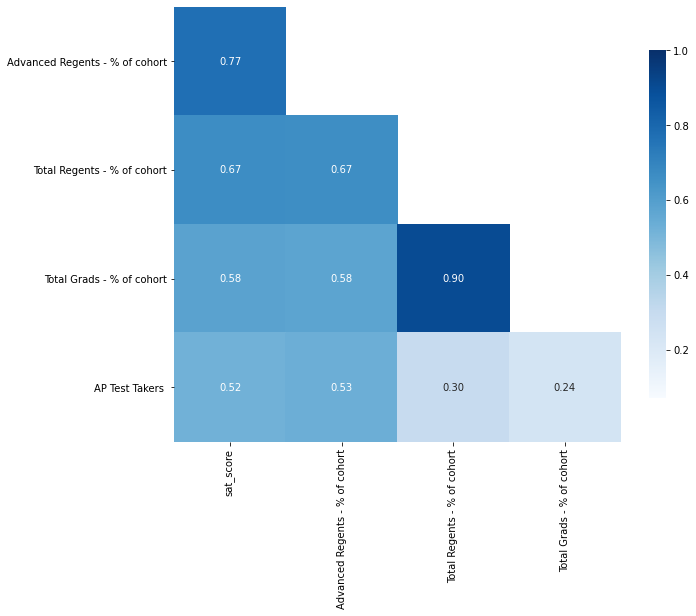

In [13]:
# create correlation matrix
acad_corr = combined.loc[:, ['sat_score', 'Advanced Regents - % of cohort', 
                             'Total Regents - % of cohort', 'Total Grads - % of cohort', 'AP Test Takers ']]
correlations = acad_corr.corr()

fig, ax = plt.subplots(figsize=(10, 8))

# create mask with half of the matrix
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# adjust mask and dataframe deleting the main diagonal row
mask = mask[1:, :-1]
corr = correlations.iloc[1:,:-1].copy()

# plot heatmap
sb.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='Blues',
           vmin=0.07, vmax=1, cbar_kws={'shrink': .8})
# yticks
plt.yticks(rotation=0)
plt.show()

Indeed Regent diplomas as a necessary requirement lead to graduation, while high SAT performance and Advanced Regent diplomas have a lower correlation to graduation outcomes, but are more strongly correlated to each other. 

They can be regarded as a way to measure academic over-performance, while Regent diplomas form a baseline enabling students to graduate.

AP tests seem to correlate significantly *less* to other factors. Let's examine them in detail.

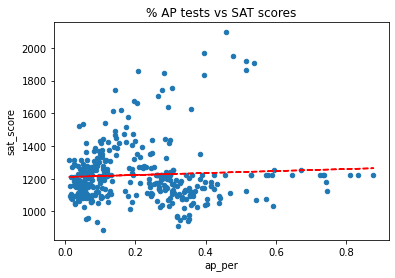

In [50]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
# create scatterplot
combined.plot('ap_per', 'sat_score', kind='scatter', title='% AP tests vs SAT scores')

# add trendline
z = np.polyfit(combined['ap_per'], combined['sat_score'], 1)
p = np.poly1d(z)
plt.plot(combined['ap_per'],p(combined['ap_per']),'r--')

Number of students who take AP exams can be correlated to high SAT performance but there are several clusters of schools. For most of them correlation is not so significant (in the group from 0 to 15% average SAT scores are higher as for the group with 20-40%). 

There is only one group of schools with SAT scores more than 1600 that shows strong correlation while also there is a group of schools where despite the high percentage of AP exam takers the SAT scores are not higher than average. 

Let's have a look at the last group.

In [15]:
combined[combined['ap_per'] > 0.6]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,Location 1,ap_per
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,0,0,0,"Academic Bowl, ACT and SAT Test Preparation, A...",Basketball,0,0,"Basketball, Cross Country, Track, Volleyball","223 East 23 Street\nNew York, NY 10010\n(40.73...",0.741545
31,02M427,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,0,0,0,"Strings Program, Leadership, Student Governmen...","Baseball, Basketball","Basketball, Softball, Volleyball",0,0,"111 East 33Rd Street\nNew York, NY 10016\n(40....",0.737308
33,02M438,INTERNATIONAL HIGH SCHOOL AT UNION SQUARE,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,0,0,0,"Before- and After-school Tutoring, Film, Stude...","Baseball, Baseball & JV Baseball, Basketball, ...","Basketball, Softball, Volleyball & JV Volleyball",Handball,"New York Road Runners Team, Biking Club","40 Irving Place\nNew York, NY 10003\n(40.73551...",0.733118
50,02M605,HUMANITIES PREPARATORY ACADEMY,36,426.000000,403.000000,426.000000,1255.000000,0,129.028846,197.038462,...,0,0,0,"Consensus-based decision-making, Critical Frie...","Baseball, Basketball & JV Basketball, Bowling,...","Basketball, Handball, Soccer, Softball, Tennis...","Bowling, Tennis",Table Tennis (Ping-Pong),"351 West 18 Street\nNew York, NY 10011\n(40.74...",0.672025
83,06M423,HIGH SCHOOL FOR EXCELLENCE AND INNOVATION,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,English Literature and Composition,0,0,"Arts and Cultural Trips, Photography Class, Co...",0,0,0,"Boys: Baseball, Basketball, Flag Football, Tra...","650 Academy Street\nNew York, NY 10034\n(40.86...",0.724881
111,08X432,BRONX BRIDGES HIGH SCHOOL,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,"Biology, Calculus AB, Spanish Language and Cul...","French Language and Culture, French Literature","Arabic, Bengali","African Dance, Art, Basketball, Community Just...","Baseball, Basketball, Football & JV Football, ...","Basketball, Bowling, Soccer, Softball, Tennis,...",0,"Baseball, Soccer; all PSAL sports listed above...","1980 Lafayette Avenue\nBronx, NY 10473\n(40.82...",0.832444
208,14K632,FRANCES PERKINS ACADEMY,12,382.000000,372.000000,368.000000,1122.000000,0,129.028846,197.038462,...,"English Language and Composition, United State...","English Language and Composition, United State...",0,"Drama and theater, EPIC (Shakespeare); Student...","Baseball, Basketball, Bowling, Football & JV F...",0,0,Intramural Basketball Tournaments,"50 Bedford Avenue\nBrooklyn, NY 11222\n(40.722...",0.745831
222,16K688,THE BROOKLYN ACADEMY OF GLOBAL FINANCE,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,"English Literature and Composition, Environmen...",0,0,"Art, Career Exploring, Chess, Debate Team, Eur...",0,0,0,Team First Basketball Program,"125 Stuyvesant Avenue\nBrooklyn, NY 11221\n(40...",0.811502
321,28Q325,HILLSIDE ARTS & LETTERS ACADEMY,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,"Art History, Biology, English Literature and C...",0,0,"Music, Student Government, Studio Art, Drama, ...","Baseball, Basketball, Bowling, Fencing, Footba...","Basketball, Bowling, Cross Country, Indoor Tra...",Fencing,"Cheerleading, Cricket","167-01 Gothic Drive\nJamaica, NY 11432\n(40.71...",0.645144
335,29Q326,CAMBRIA HEIGHTS ACADEMY,s,404.119403,419.656716,399.662687,1223.438806,0,129.028846,197.038462,...,"English Literature and Composition, Environmen...",Calculus AB,"English, French, Spanish","Art, Basketball, Bowling, Choru

Part of these high schools is [**transfer schools**](https://www.schools.nyc.gov/enrollment/other-ways-to-graduate/transfer-high-schools). That means that their programs are specially designed to re-engage students who have dropped out or fallen behind in credits. 
 
Second part of them are migrant-oriented or highly specialized high schools. Part of their strategy is to increase number of AP courses and ['to encourage any hard-working students, not just high-achievers, to take more challenging classes.'](https://professionals.collegeboard.org/testing/states-local-governments/partnerships/nyc/ap-all)
 
So **AP exams** could be regarded as an alternative form to increase chances of graduation that is taken as an adaptive strategy to integrate students that are either good in very specific areas or are more challenged with learning English (mostly from the migrant families).
 
Next step is to check how does the school environment influence academic performance.


## Learning environment factors
 
Best way to approach this topic is to examine data from the high school survey and take a look at class sizes. 
 
 
### Find correlations with survey evaluations
 
During the survey teachers, parents and students of public high schools were asked to evaluate their school for 4 parameters with scores from 1 to 10:
 - safety and respect
 - communication
 - engagement
 - academic expectations
 
Let's check if there is correlation of high SAT performance with any of these parameters.


In [16]:
# Remove DBN from list of survey fields
survey_fields.remove('dbn')

<AxesSubplot:>

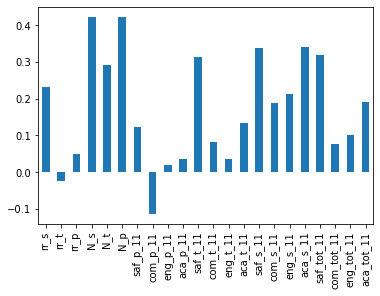

In [17]:
# create correlation bar plot survey fields vs SAT scores correlation 
combined.corr()['sat_score'][survey_fields].plot.bar()

Top factors having positive correlation with high SAT scores were *number of students and parents that took part in survey* and response rate from the students. That should be examined further in connection to the class sizes.
 
Another significant factor is high safety and respect levels: high safety estimations by students ('saf_s_11') and teachers ('saf_t_11') are moderately correlated with high SAT performance.
 
What is especially interesting, that high academic expectations from teachers ('aca_t_11') or parents ('aca_p_11') very slightly correlate to actual performance while students' expectations ('aca_s_11') do.
 
### How do learning environment parameters correlate with each other?
 
Since several parameters don't show significant correlation to high SAT performance. Let's check how they relate to each other.


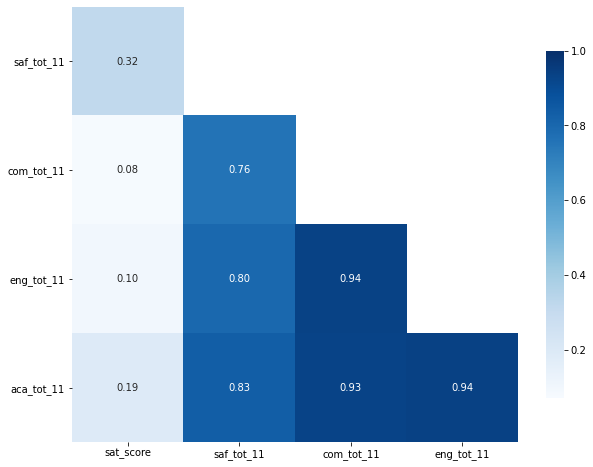

In [18]:
# create correlation matrix
survey_corr = combined.loc[:, ['sat_score', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']]
correlations = survey_corr.corr()

fig, ax = plt.subplots(figsize=(10, 8))

# create mask with half of the matrix
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# adjust mask and dataframe deleting the main diagonal row
mask = mask[1:, :-1]
corr = correlations.iloc[1:,:-1].copy()

# plot heatmap
sb.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='Blues',
           vmin=0.07, vmax=1, cbar_kws={'shrink': .8})
# yticks
plt.yticks(rotation=0)
plt.show()

Average measures calculated from scores of teachers, parents and students prove once more that safety is connected to high academic performance. 
 
Other factors show more strong covariance with each other: coefficients for engagement, communication and academic expectations all are over 0.9. Probably these factors show how comfortable the environment is for its members (first of all parents and teachers), but it doesn't affect the academic performance of the students.
 
### Evaluating safety and respect factor


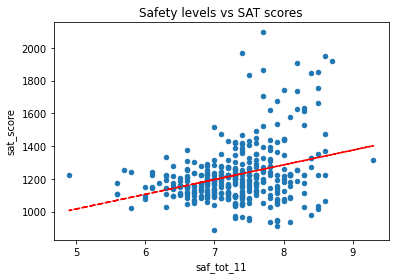

In [51]:
# create scatterplot
combined.plot('saf_tot_11', 'sat_score', kind='scatter', title='Safety levels vs SAT scores')

# add trendline
z = np.polyfit(combined['saf_tot_11'], combined['sat_score'], 1)
p = np.poly1d(z)
plt.plot(combined['saf_tot_11'],p(combined['saf_tot_11']),"r--")


In [52]:
group_boro = combined.groupby(["boro"]).mean()
print(group_boro['sat_score'].sort_values(ascending=True))

print('Will average safety levels have the same distribution?')

print(group_boro['saf_tot_11'].sort_values(ascending=True))

boro
Bronx            1157.598203
Brooklyn         1181.364461
Manhattan        1278.331410
Queens           1286.753032
Staten Island    1382.500000
Name: sat_score, dtype: float64
Will average safety levels have the same distribution?
boro
Brooklyn         7.129245
Staten Island    7.200000
Bronx            7.322581
Queens           7.387500
Manhattan        7.473333
Name: saf_tot_11, dtype: float64


On the one hand schools from Bronx and Brooklyn with the lowest mean SAT scores also are evaluated with lower safety levels, while Queens and Manhattan got higher safety ratings also having higher SAT scores. 

Interesting exception from that trend is a borough of *Staten Island* which was evaluated with low safety levels while having over-average SAT scores. 

<AxesSubplot:title={'center':'Safety levels vs SAT scores at Staten Island'}, xlabel='saf_tot_11', ylabel='sat_score'>

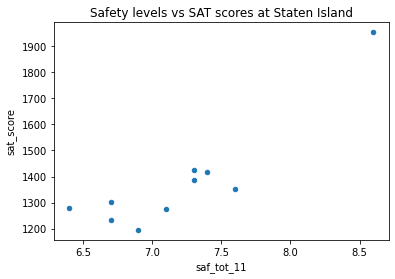

In [21]:
st_island = combined[combined['boro'] == 'Staten Island']
st_island.plot('saf_tot_11', 'sat_score', kind='scatter', title='Safety levels vs SAT scores at Staten Island')

In [22]:
print(st_island[st_island['sat_score'] > 1600][['DBN', 'SchoolName', 'sat_score', 'saf_tot_11']])

        DBN                  SchoolName  sat_score  saf_tot_11
356  31R605  STATEN ISLAND TECHNICAL HS     1953.0         8.6


The only borough that doesn't follow the trend, Staten Island, has few schools - 10 (at least in that dataset), with one clear outlier with the high levels of SAT scores and high level of safety (Staten Island Technical High School). Probably it's SAT scores affect average values stronger than safety levels.

### Choropleth map of safety levels and SAT scores
 
Next step is to visualize how average safety levels and average SAT scores vary across the area of New York. I decided to make a choropleth map based on zip codes of the schools, not to focus on the borough borders.
 
The shapefile of zip codes borders of New York City was downloaded from the NYC OpenData portal [here](https://github.com/CityOfNewYork/nyc-geo-metadata/blob/master/Metadata/Metadata_ZipCodeBoundaries.md). I have placed a folder with all files included in the shapefile to the folder 'schools' and read nyu_2451_34509.shp file.
 
I will use the `geopandas` library which enables me to work with shapefiles and process them in the similar way to pandas dataframes.

In [23]:
# read shapefile and create gdf
shapefile = 'schools/ny-zip/nyu_2451_34509.shp'
zip_map = gpd.read_file(shapefile)
zip_map.head()

,zcta,bcode,note,geometry
0,10001,36061,None,"POLYGON ((-74.00368 40.74835, -74.00653 40.749..."
1,10002,36061,None,"POLYGON ((-73.99695 40.71207, -73.99712 40.712..."
2,10003,36061,None,"POLYGON ((-73.99206 40.72564, -73.99179 40.726..."
3,10007,36061,None,"POLYGON ((-74.01046 40.71153, -74.01015 40.712..."
4,10009,36061,None,"POLYGON ((-73.97521 40.71924, -73.97512 40.719..."


In [24]:
# convert zip codes to integers
zip_map['zcta'] = zip_map['zcta'].astype('int64')

<AxesSubplot:>

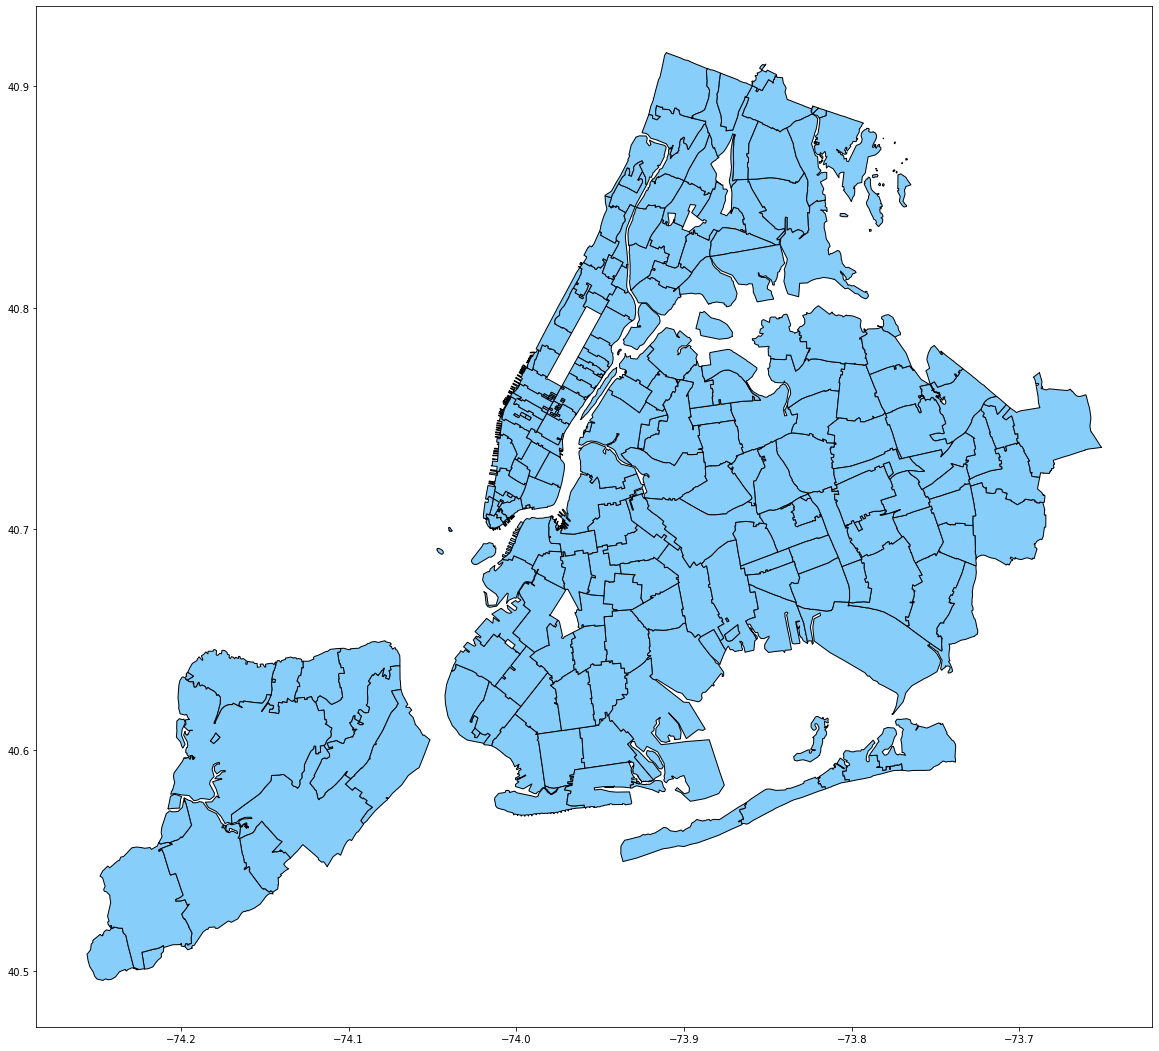

In [25]:
# check how the map looks like
fig,ax = plt.subplots(figsize=(20, 20))
zip_map.plot(ax=ax, color='lightskyblue', edgecolor='black')

In [26]:
# calculate average safety score for every zip code
avg_saf = pd.pivot_table(combined, values='saf_tot_11', index=['zip'], aggfunc=np.mean)
avg_saf.reset_index(inplace=True)
avg_saf['saf_tot_11'].describe()

count    116.000000
mean       7.308582
std        0.535415
min        5.600000
25%        7.000000
50%        7.315341
75%        7.600000
max        8.600000
Name: saf_tot_11, dtype: float64

In [27]:
# calculate average SAT score for every zip code
avg_sat = pd.pivot_table(combined, values='sat_score', index=['zip'], aggfunc=np.mean)
avg_sat.reset_index(inplace=True)
avg_sat['sat_score'].describe()

count     116.000000
mean     1253.039597
std       156.921921
min       951.000000
25%      1145.914552
50%      1223.438806
75%      1317.898028
max      2096.000000
Name: sat_score, dtype: float64

In [28]:
# merge two datasets based on zip codes
merged = zip_map.set_index('zcta').join([avg_sat.set_index('zip'), avg_saf.set_index('zip')])

merged.drop(columns='note', inplace=True)
merged.reset_index(inplace=True)
merged.head()

,zcta,bcode,geometry,sat_score,saf_tot_11
0,10001,36061,"POLYGON ((-74.00368 40.74835, -74.00653 40.749...",NaN,NaN
1,10002,36061,"POLYGON ((-73.99695 40.71207, -73.99712 40.712...",1306.090909,7.309091
2,10003,36061,"POLYGON ((-73.99206 40.72564, -73.99179 40.726...",1232.219403,7.325000
3,10007,36061,"POLYGON ((-74.01046 40.71153, -74.01015 40.712...",NaN,NaN
4,10009,36061,"POLYGON ((-73.97521 40.71924, -73.97512 40.719...",1149.000000,7.900000


Text(-74.2, 40.5, 'Source: NYC OpenData portal 2014')

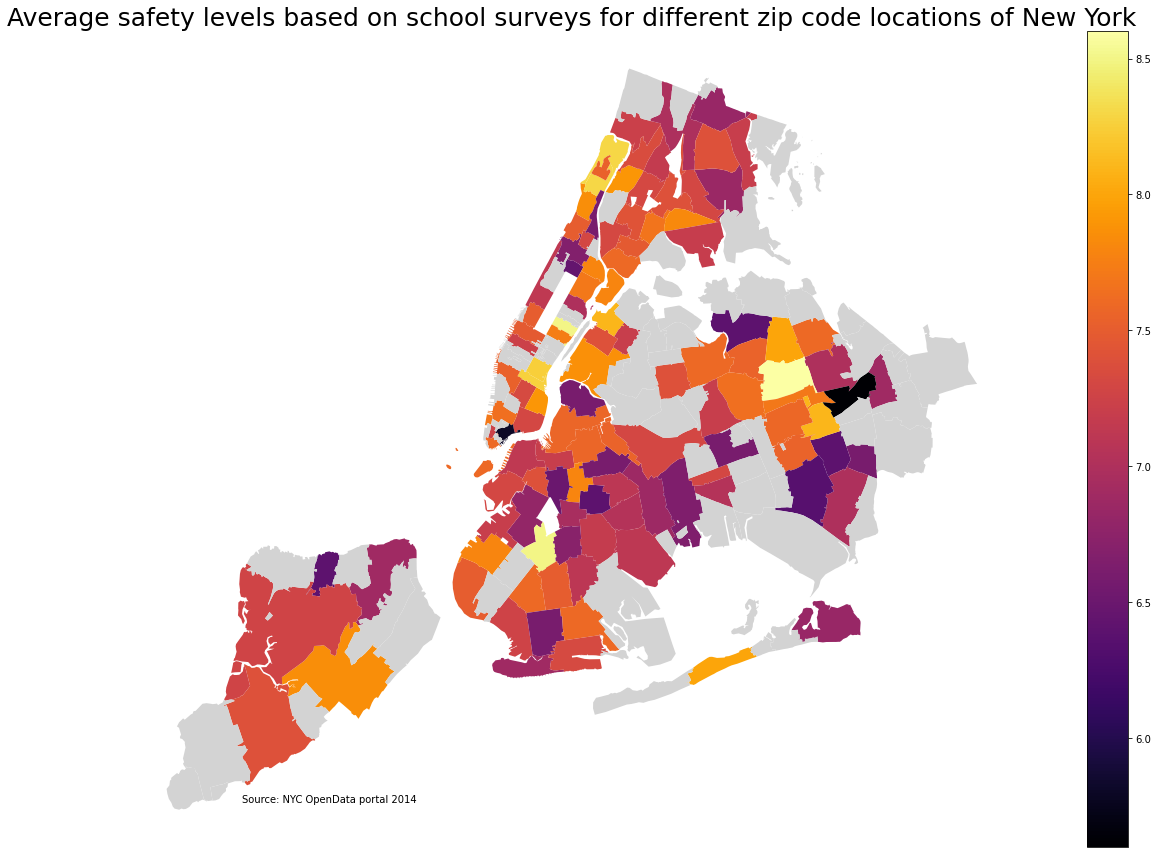

In [29]:
# create a map of safety levels
fig,ax = plt.subplots(1, figsize=(25, 15))
merged['coords'] = merged['geometry'].apply(lambda x:x.representative_point().coords[:])
merged.plot(column='saf_tot_11', ax=ax, cmap='inferno', figsize=(16,10), legend=True,  missing_kwds={'color': 'lightgrey'})

# delete axis
ax.axis('off')

# add a title
ax.set_title('Average safety levels based on school surveys for different zip code locations of New York City', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: NYC OpenData portal 2014', xy=(-74.2, 40.50), fontsize=10)

Text(-74.2, 40.5, 'Source: NYC OpenData portal 2014')

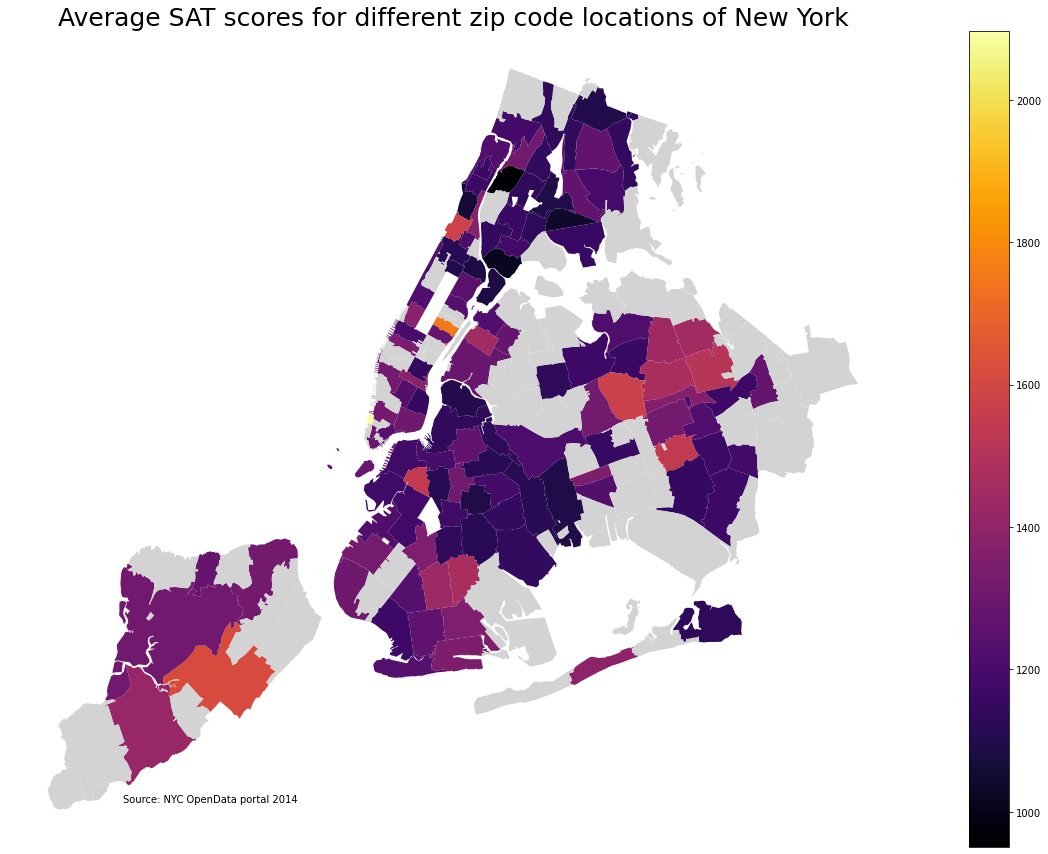

In [30]:
# create a map of SAT scores
fig,ax = plt.subplots(1, figsize=(25, 15))
merged['coords'] = merged['geometry'].apply(lambda x:x.representative_point().coords[:])
merged.plot(column='sat_score', ax=ax, cmap='inferno', figsize=(16,10), legend=True,  missing_kwds={'color': 'lightgrey'})

# delete axis
ax.axis('off')

# add a title
ax.set_title('Average SAT scores for different zip code locations of New York', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: NYC OpenData portal 2014', xy=(-74.2, 40.50), fontsize=10)

The distribution of average SAT scores indicates several areas with the higher scores: Staten Island, north-easten parts of Queens and some areas of Manhattan. The districts with lowest SAT scores are Bronx borough and eastern part of Brooklyn. 
 
Based on safety evaluations roughly the same areas as with top average SAT scores are also relatively safe: Manhattan, Staten Island and some north-eastern parts of Queens, as well as north-western part of Brooklyn (the latest although has lower SAT scores).

### Average class size - how does it affect SAT performance?
Class size is often used in school evaluation as a metric for school administration quality (as we can see also in statistical reports from [Berlin, Germany](https://www.statistik-berlin-brandenburg.de/publikationen/stat_berichte/2019/SB_B01-01-00_2017j01_BE.pdf)). So we expect smaller classes to be connected to higher SAT performance.

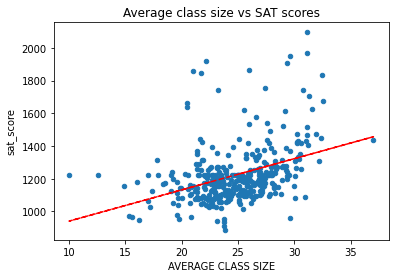

In [31]:
# create scatterplot
combined.plot('AVERAGE CLASS SIZE', 'sat_score', kind='scatter', title='Average class size vs SAT scores')

#add trendline
z = np.polyfit(combined['AVERAGE CLASS SIZE'], combined['sat_score'], 1)
p = np.poly1d(z)
plt.plot(combined['AVERAGE CLASS SIZE'], p(combined['AVERAGE CLASS SIZE']), 'r--')

The scatterplot reveals an interesting trend: class size has a positive correlation to SAT scores, so our hypothesis was not confirmed by the data. 

Let's check the group of schools with average class sizes < 20 and a low SAT performance. Are there any peculiarities that can affect that relationship? 

In [32]:
combined[(combined['AVERAGE CLASS SIZE']<20)&(combined['sat_score']<1200)]['SCHOOL NAME']

6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
8                                   ESSEX STREET ACADEMY
35                                  VANGUARD HIGH SCHOOL
55          URBAN ASSEMBLY SCHOOL FOR MEDIA STUDIES, THE
68                                 PARK EAST HIGH SCHOOL
91                   INTERNATIONAL COMMUNITY HIGH SCHOOL
106    PABLO NERUDA ACADEMY FOR ARCHITECTURE AND WORL...
108      HOLCOMBE L. RUCKER SCHOOL OF COMMUNITY RESEARCH
126                      BRONX INTERNATIONAL HIGH SCHOOL
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
188                   BROOKLYN INTERNATIONAL HIGH SCHOOL
208                              FRANCES PERKINS ACADEMY
238                           BROOKLYN GENERATION SCHOOL
243    HIGH SCHOOL FOR INNOVATION IN ADVERTISING AND ...
244           CULTURAL ACADEMY FOR THE ARTS AND SCIENCES
246         ACADEMY FOR CONSERVATION AND THE ENVIRONMENT
265               INTERNATIONAL HIGH SCHOOL AT LAFAYETTE
286               PAN AMERICAN 

Whilst some of the schools in that list are more migrant focused (usually include the word 'international'), or tailored for students with special needs (like The American Sign Language and english secondary school), but the group doesn't consist of them exclusively.

In my opinion, it could also be connected to the trend that larger numbers of students participating in the school survey (that is equal to larger school size) also tend to get higher SAT scores.

Let's check how the school size is correlated to the sat_scores:

In [33]:
combined.corr()['sat_score']['total_enrollment']

0.3678569169880295

Slight positive correlation of school size to high SAT scores could mean that number of peers could influence performance. But that hypothesis needs to be examined with more data, maybe in chronological development.

## Demographic factors

Next step is to look at *gender* and *race* of students and see how these factors influence academic performance.
 
 
### Gender difference in SAT performance
 
Next step is to see how gender correlates with high SAT scores.


<AxesSubplot:>

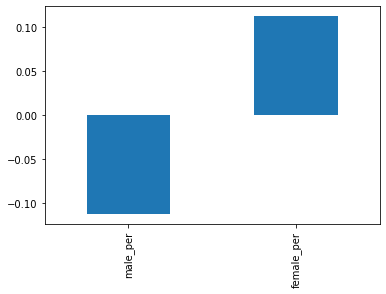

In [34]:
# create bar plot on gender vs SAT scores correlation 
combined.corr()['sat_score'][['male_per', 'female_per']].plot.bar()

Female gender shows slight positive correlation (with correlation coefficient = 0.1) while male gender - slightly negative (correlation coefficient = -0.1). 

Let's investigate in detail which schools with high SAT performance also include relatively more female students.

<AxesSubplot:title={'center':'% of female students vs SAT scores'}, xlabel='female_per', ylabel='sat_score'>

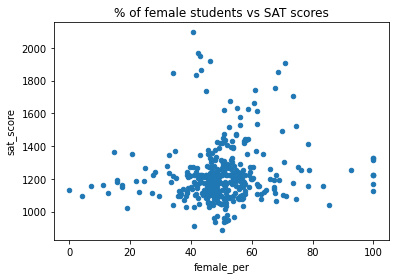

In [35]:
combined.plot('female_per', 'sat_score', kind='scatter', title='% of female students vs SAT scores')

Most part of schools fall into group with share of female students between *40 and 60%* which is expectable - today schools have mixed-gender classes. 
 
Female gender though doesn't look like a very strong factor for high academic performance.

 Let's have a look at schools with the highest share of female students, maybe it's not a gender percentages but some other factors are working here?

In [36]:
combined[(combined['female_per'] > 60)&(combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [37]:
combined[combined['female_per'] > 80]['SCHOOL NAME']

15     URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...
49                 THE HIGH SCHOOL OF FASHION INDUSTRIES
70                       YOUNG WOMEN'S LEADERSHIP SCHOOL
71                       YOUNG WOMEN'S LEADERSHIP SCHOOL
104                        WOMEN'S ACADEMY OF EXCELLENCE
133                     HIGH SCHOOL FOR VIOLIN AND DANCE
137    THE MARIE CURIE SCHOOL FOR MEDICINE, NURSING, ...
191    URBAN ASSEMBLY INSTITUTE OF MATH AND SCIENCE F...
264       THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE
329              YOUNG WOMEN'S LEADERSHIP SCHOOL, QUEENS
338             YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA
Name: SCHOOL NAME, dtype: object

Schools with predominance of female students either have specialized programs that usually attract more female students (fashion, music, nursing) or focused exclusively on women education. 
 
Latter schools could be very important to attract girls from traditionalist muslim families for which mixed-gender education could be unecceptable. As is clear from the scatterplot though the SAT performance of students of these schools lay below average. The reasons for that could be a small size of these schools (reduced number of peers?) or another vector of attitudes.
 
Next step is to check the race groups of students.

### Race groups

There are a few columns that indicate the percentage of each race at a given school:
 - white_per
 - asian_per
 - black_per
 - hispanic_per
 
By exploring how average SAT scores differ among these groups I'll see if there is any systematic difference. More information on the racial group terminology can be found [here](https://grants.nih.gov/grants/guide/notice-files/not-od-15-089.html).

<AxesSubplot:>

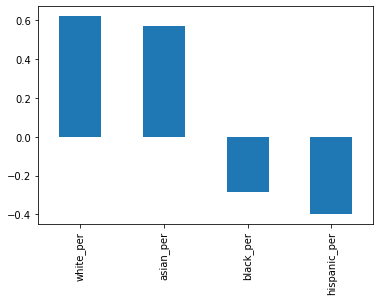

In [38]:
# create bar plot on race vs SAT scores correlation 
race_groups = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()["sat_score"][race_groups].plot.bar()

Based on the plot there is a strong positive correlation with percentage of White and Asian students, while percentage of Hispanic students has some negative correlation with high average SAT scores. Black student proportion also shows slightly negative correlation.

<AxesSubplot:title={'center':'% of hispanic students vs SAT scores'}, xlabel='hispanic_per', ylabel='sat_score'>

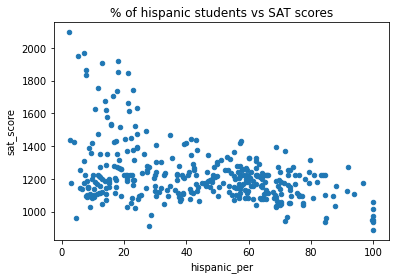

In [53]:
# create scatterplot
combined.plot('hispanic_per', 'sat_score', kind='scatter', title='% of hispanic students vs SAT scores')

Starting from >25% of hispanic students the average SAT scores are significantly lower. 
 
The group with lowest SAT scores are schools with 100% of hispanic population. Let's have a look at them.

In [40]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

After short research on these schools I found that most of them are aimed at newly arrived migrants and offer programs to learn English. That could easily explain below-average performance at SAT tests.

What about the schools which outperform on SAT and have <20% of hispanic students?

In [41]:
combined[(combined['hispanic_per'] < 20)&(combined['sat_score'] > 1790)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools in that list are called public magnets. These are schools with specialized courses or curricula including advanced college programs. "Magnet" refers to how the schools draw students from across the normal boundaries defined by authorities (usually school boards). Students admitted there should get high notes at Specialized Science High School Admissions test. More information on public magnet schools could be found [there.](https://www.magnetschools.nyc/)
 
Let's see how does racial diversity looks in schools with higher SAT scores.


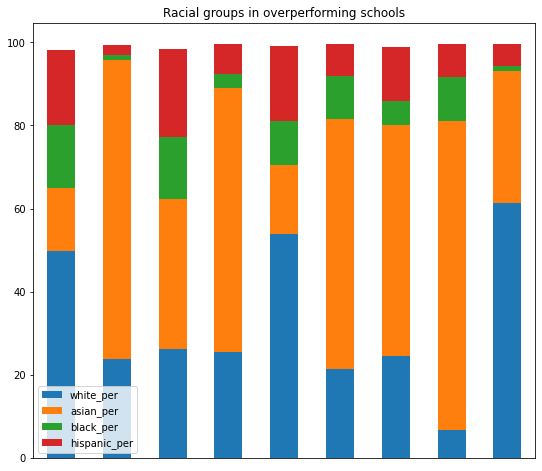

In [42]:
combined[combined['sat_score'] > 1790].plot(x="SCHOOL NAME", y=race_groups, kind="bar", stacked=True, title='Racial groups in overperforming schools', figsize=(9,8)).axes.get_xaxis().set_visible(False)

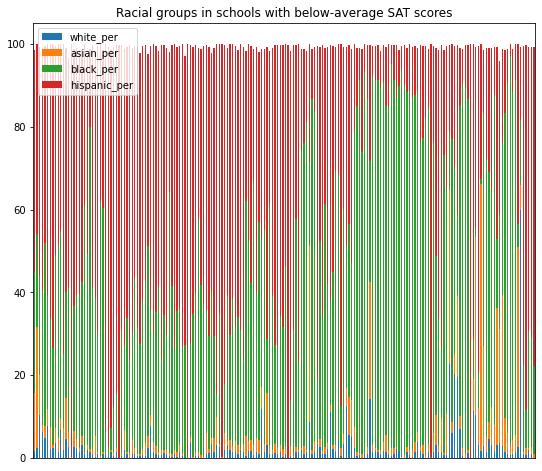

In [43]:
combined[combined['sat_score'] < 1200].plot(x="SCHOOL NAME", y=race_groups, kind="bar", stacked=True, title='Racial groups in schools with below-average SAT scores', figsize=(9,8)).axes.get_xaxis().set_visible(False)

As we can see over-performers tend to have more asian and white students as schools with below-average SAT scores tend to include predominantly black and hispanic students.
That trend is systemic and applies for the majority of NYC schools. 
What can be the core reason for that? Earlier when I created a map with SAT score distribution several geographical clusters were found with below-average performance. My hypothesis is that there are 2 factors that define strong academic performance: 
- native English
- high household income
 
### Income factors
 
The data that could give some approximation to the socio-economic context in which students live is a percentage of students who get free or reduced lunches. The main condition for that option is a below-average income of the family.
 
### Choropleth map of % of free/reduced lunches


In [44]:
# calculate average proportion of free/reduced lunches for every zip code

avg_frl = pd.pivot_table(combined, values='frl_percent', index=['zip'], aggfunc=np.mean)
avg_frl.reset_index(inplace=True)
avg_frl['frl_percent'].describe()

count    116.000000
mean      62.324886
std       15.661436
min       15.800000
25%       52.200000
50%       65.676190
75%       71.855000
max       99.200000
Name: frl_percent, dtype: float64

In [45]:
merged = zip_map.set_index('zcta').join(avg_frl.set_index('zip'))
merged.reset_index(inplace=True)
merged.head()

,zcta,bcode,note,geometry,frl_percent
0,10001,36061,None,"POLYGON ((-74.00368 40.74835, -74.00653 40.749...",NaN
1,10002,36061,None,"POLYGON ((-73.99695 40.71207, -73.99712 40.712...",61.709091
2,10003,36061,None,"POLYGON ((-73.99206 40.72564, -73.99179 40.726...",72.650000
3,10007,36061,None,"POLYGON ((-74.01046 40.71153, -74.01015 40.712...",NaN
4,10009,36061,None,"POLYGON ((-73.97521 40.71924, -73.97512 40.719...",71.800000


Text(-74.2, 40.5, 'Source: NYC OpenData portal 2014')

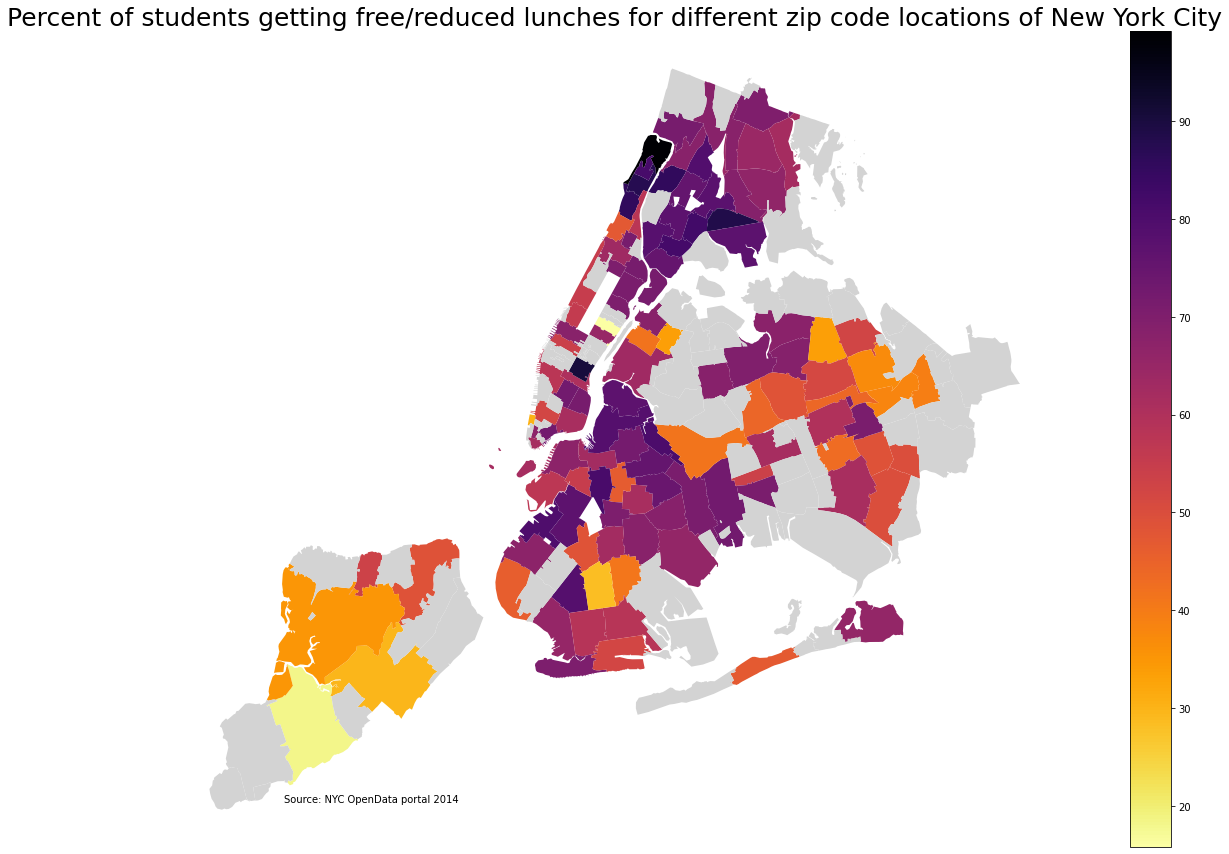

In [54]:
# create a map with zip codes
fig,ax = plt.subplots(1, figsize=(25, 15))
merged['coords'] = merged['geometry'].apply(lambda x:x.representative_point().coords[:])
merged.plot(column='frl_percent', ax=ax, cmap='inferno_r', figsize=(16,10), legend=True,  missing_kwds={'color': 'lightgrey'})

# delete axis
ax.axis('off')

# add a title
ax.set_title('Percent of students getting free/reduced lunches for different zip code locations of New York City', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: NYC OpenData portal 2014', xy=(-74.2, 40.50), fontsize=10)

The areas with the highest proportion of students getting free/reduced meals shows that areas with lower SAT scores tend also to have larger numbers of low-income families. That is certainly a systematic gap, that could also be connected to the migrant status of these families. 

To check these hypotheses I create a correlation matrix between 'sat_scores', 'frl_percent' and 'ell_percent'. The last parameter is a share of English Language Learners that could be higher in schools with migrant students.


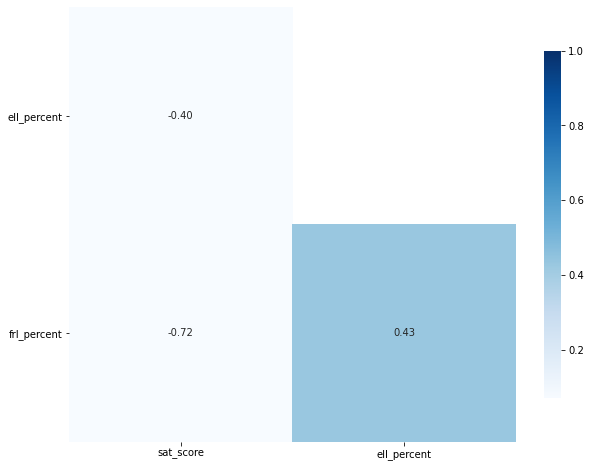

In [49]:
# create correlation matrix
soc_econ_corr = combined.loc[:, ['sat_score', 'ell_percent', 'frl_percent']]
correlations = soc_econ_corr.corr()

fig, ax = plt.subplots(figsize=(10, 8))

# create mask with half of the matrix
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# adjust mask and dataframe deleting the main diagonal row
mask = mask[1:, :-1]
corr = correlations.iloc[1:,:-1].copy()

# plot heatmap
sb.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='Blues',
           vmin=0.07, vmax=1, cbar_kws={'shrink': .8})
# yticks
plt.yticks(rotation=0)
plt.show()

The income of the family has more impact on SAT test performance as the number of English Language Learners. There could be several explanation for that:

- language proficiency is not the important factor determining academic performance (other observations on migrant-oriented schools don't fully confirm that statement)
- the measure 'ell_percent' doesn't reflect the proportion of migrant students

# Conclusion
 
## What is a high academic performance?
 
High Scholastic Aptitude Test (SAT) scores are not the only way to measure academic performance. Other ways are also the proportion of Advanced Regent and Regent diplomas and graduation rates directly connected to them. Advanced Placement test performance showcases more specialized proficiency and is not so strongly connected to graduation outcomes.
 
## Important factors that are correlated to high SAT scores
 
After examination of measures connected to the school environment and demographics enables me to see that there is a systemic problem with lack of racial diversity at high schools. The result of that system is the following trend: in the areas with compact residence of low-income population, more often consisting of two racial groups the average SAT performance is lower than average. Lack of knowledge of English language could affect migrant students (probably the difference in correlation coefficients between Black/Hispanics can be explained that among the last group there are more newcomers with less English proficiency).

The key factor of school environment is a high level of safety and respect for students. Other factors don't seem to be so closely connected to high SAT scores.
 
 
## Ways to address this problem and to further investigate it

My short exploratory analysis also showed some steps NYC authorities took to tackle the problem of low high school diversity: 
- public magnet schools aim to overcome the borders of residence areas
- introduction of more AP courses could also an alternative strategy to provide in-depth knowledge to the students who have below-average overall academic performance.
 
Further study of the problem should include latest datasets to provide an historic perspective on efficiency of these steps.
